Questions
- Convergence warning on the year logistic?
- N used main crimecode for his regression...

# Getting and cleaning the data

In [9]:
# Loads the modules
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm
import requests
import json
from statsmodels.formula.api import ols
from statsmodels.formula.api import logit
import datetime
import calendar
from sklearn.cross_validation import train_test_split
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
# Loads the data
base_url = 'https://raw.githubusercontent.com/aisaacso/SafeBoss/master/'
crime_url = base_url + 'Crime_Incident_Reports.csv'
crime = pd.read_csv(crime_url)

/Users/annaisaacson/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Cleans the data

# Converts FROMDATE from str to datetime
crime['FROMDATE'] = pd.to_datetime(crime.FROMDATE, format = '%m/%d/%Y %I:%M:%S %p')

# Lops off data from July, 2012 to August, 2012, so that we have full years (not sure this matters)
crime = crime[crime.FROMDATE > '2012-08-10 00:00:00']

#Add a date column
crime['Date'] = crime.FROMDATE.dt.date

#Add a column for the month name
def mo_as_name(mo):
    return calendar.month_name[mo]

crime['MoName'] =  crime['Month'].map(mo_as_name)

In [4]:
# Dummy for shooting
def shoot_dummy(v):
    if v=='Yes':
        return 1
    else:
        return 0
    
crime['Shooting'] = crime['Shooting'].map(shoot_dummy)

# this doesn't work for some reason...maybe because Shooting is objects, not strings?
#crime['Shoot_dumb'] = crime['Shooting'].map({0:'No', 1:'Yes'})
# eventually, do this inline, like #train_df['alive?'] = train_df['Survived'].map({0:'dead', 1:'alive'}) 

In [5]:
# Adds weather data to crime data
weather_url = base_url + 'weather.csv'
weather = pd.read_csv(weather_url)
weather = weather[weather.STATION == 'GHCND:USW00014739']
weather['Date'] = pd.to_datetime(weather.DATE, format = '%Y%m%d')
weather['Date'] = weather.Date.dt.date

In [6]:
# Add dummies; merge with weather; create working data set
week_dummies = pd.get_dummies(crime['DAY_WEEK']).iloc[:, 1:]
month_dummies = pd.get_dummies(crime['MoName']).iloc[:, 1:]
dist_dummies = pd.get_dummies(crime['REPTDISTRICT']).iloc[:,1:]
shift_dummies = pd.get_dummies(crime['SHIFT']).iloc[:,1:]
crtype_dummies = pd.get_dummies(crime['MAIN_CRIMECODE']).iloc[:,1:]
with_weather = pd.merge(crime, weather, how = 'outer', on = 'Date')
dummy_df = with_weather.join([week_dummies, month_dummies, dist_dummies, shift_dummies, crtype_dummies])

# Exploratory Analysis
(Still need to do more of this)

In [ ]:
# Analysis of crime time of day

# Overrides a warning that I don't really understand; should look into it more
pd.options.mode.chained_assignment = None

# Adds Hour column for each crime
crime['Hour'] = crime.FROMDATE.dt.hour

# Removes the rows that have no time -- probably needlessly complex!
crime_no_time = crime[(crime.FROMDATE.dt.hour == 0) & (crime.FROMDATE.dt.minute == 0)]
crime_no_time['no_time'] = 'indicator'
crime_time = crime.merge(crime_no_time, how='left')
crime_time = crime_time[crime_time.no_time <> 'indicator']

# Pivot table of count conditioned on hour
hours = pd.pivot_table(crime_time, values = 'DAY_WEEK', index = 'Hour', aggfunc = 'count')

#Plots the total number of crimes at each time of day
hours.plot(xticks = crime.Hour.unique(), title='Crime Count by Hour (Military Time)')

In [ ]:
# Analysis crime time of year
months = pd.pivot_table(crime, values = 'DAY_WEEK', index = 'Month', aggfunc = 'count')

#Plots crimes per day
dates = pd.pivot_table(crime, values = 'DAY_WEEK', index = ['Date', 'Year', 'Month'], aggfunc = 'count')
dates.plot()

In [ ]:
# Shows which districts have the most crime
crime_no_HTU = crime[crime.REPTDISTRICT <> 'HTU']
reptd = pd.pivot_table(crime_no_HTU, values = 'DAY_WEEK', index = 'REPTDISTRICT', aggfunc = 'count')
reptd.plot(kind = 'bar', sort_columns = True)

In [ ]:
# Shows which days have the most shootings
shootz = crime[crime.Shooting==1]
days = pd.pivot_table(shootz, values = 'COMPNOS', index = 'DAY_WEEK', aggfunc = 'count')
days.plot(kind = 'bar')

# Linear Regression: What factors contribute to crime per day?

# Logistic Regression: Given a crime, what factors contribute to crime including a shooting?

In [7]:
#Split into training and test data
train, test = train_test_split(dummy_df, test_size = 0.2)

In [ ]:
# Add year to model? NO

model_logistic = logit(data=train, formula='Shooting ~ Year')
result_logistic = model_logistic.fit()

# This will demonstrate that p value isn't high enough to justify inclusion
#result_logistic.summary()
# Is the convergence warning telling me that I don't have enough data? I only have 3 years.

In [8]:
# Regression
model_logistic = logit(data=train, formula='Shooting ~ Monday + Saturday + Sunday + Thursday + Tuesday + Wednesday \
+ August + December + February + January + July + June + March + May + November + October + September\
+ TMAX + PRCP + A15 + A7 + B2 + B3 + C11 + C6 + D14 + D4 + E13 + E18 + E5 + HTU' 
                     )
result_logistic = model_logistic.fit()
result_logistic.summary()

         Current function value: 0.017233
         Iterations: 35


/Users/annaisaacson/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Shooting   No. Observations:               201009
Model:                          Logit   Df Residuals:                   200977
Method:                           MLE   Df Model:                           31
Date:                Sun, 24 Apr 2016   Pseudo R-squ.:                 0.01298
Time:                        10:44:52   Log-Likelihood:                -3464.0
converged:                      False   LL-Null:                       -3509.6
                                        LLR p-value:                 7.900e-08
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -7.6510      0.450    -17.006      0.000        -8.533    -6.769
Monday         0.3199      0.167      1.910      0.056        -0.008     0.648
Saturday      -0.0142      0.181     -0.078      0.938        -0.369     0.341
Sunday         0.2789      0.173      1.608      0.108        -0.061     0.619
Thursday       0.3558      0.165      2.160      0.031         0.033     0.679
Tuesday        0.1573      0.175      0.901      0.368        -0.185     0.499
Wednesday      0.2503      0.169      1.482      0.138        -0.081     0.581
August         0.2219      0.218      1.017      0.309        -0.206     0.650
December       0.7149      0.294      2.435      0.015         0.139     1.290
February       0.3869      0.282      1.374      0.169        -0.165     0.939
January        0.3316      0.319      1.040      0.298        -0.293     0.957
July           0.3088      0.222      1.389      0.165        -0.127     0.744
June           0.2869      0.215      1.337      0.181        -0.134     0.707
March          0.5226      0.225      2.326      0.020         0.082     0.963
May            0.2196      0.214      1.025      0.305        -0.200     0.640
November       0.4734      0.295      1.605      0.109        -0.105     1.052
October        0.2862      0.262      1.092      0.275        -0.228     0.800
September     -0.0122      0.240     -0.051      0.960        -0.483     0.459
TMAX           0.0201      0.005      3.835      0.000         0.010     0.030
PRCP          -0.6085      0.228     -2.668      0.008        -1.055    -0.162
A15           -0.1247      0.343     -0.364      0.716        -0.797     0.547
A7            -0.1712      0.255     -0.671      0.502        -0.671     0.329
B2             0.1035      0.169      0.611      0.541        -0.229     0.436
B3            -0.2099      0.207     -1.012      0.311        -0.616     0.197
C11            0.0907      0.176      0.516      0.606        -0.254     0.435
C6            -0.1756      0.216     -0.812      0.417        -0.600     0.248
D14            0.0068      0.209      0.033      0.974        -0.403     0.417
D4            -0.1462      0.182     -0.805      0.421        -0.502     0.210
E13            0.0743      0.221      0.337      0.736        -0.358     0.507
E18           -0.6564      0.298     -2.202      0.028        -1.241    -0.072
E5             0.2373      0.225      1.053      0.292        -0.204     0.679
HTU          -10.9603   2012.968     -0.005      0.996     -3956.304  3934.384
==============================================================================
"""

# Crimes of business concern
Team: The charts below show the streets with the most business crimes for each district.
How do we want to go about turning this into a statistics question?

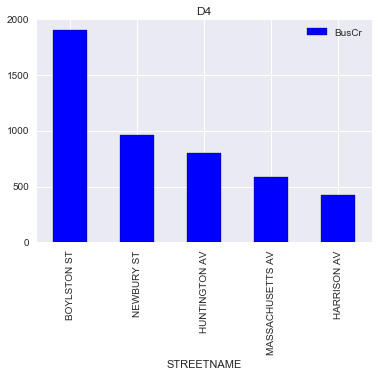

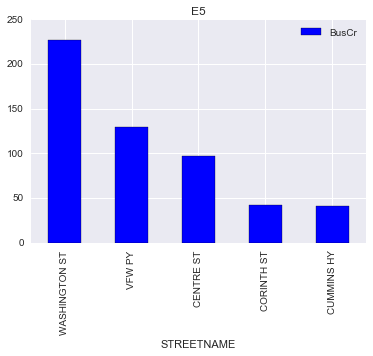

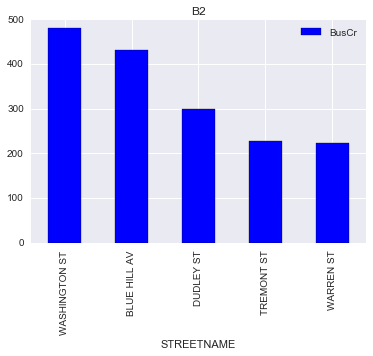

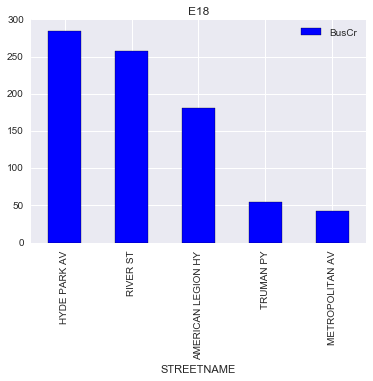

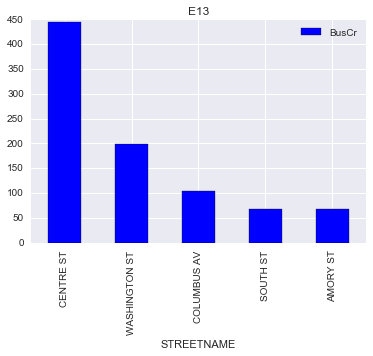

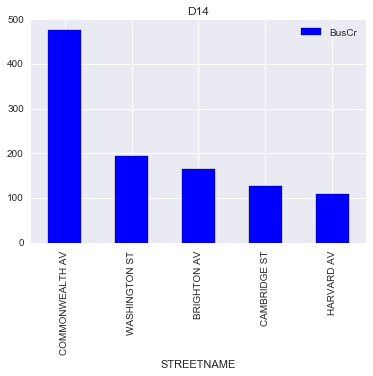

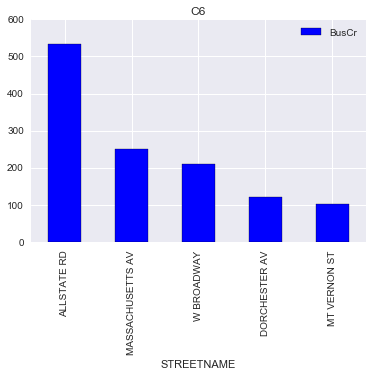

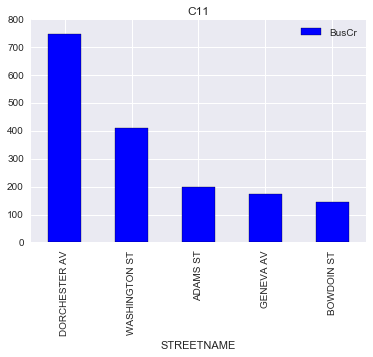

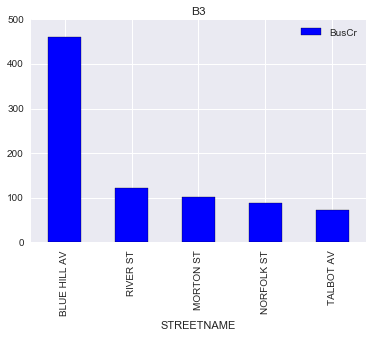

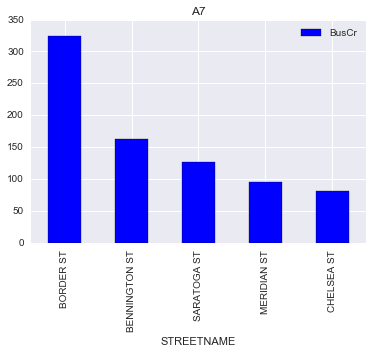

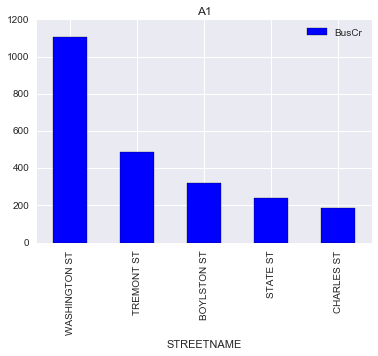

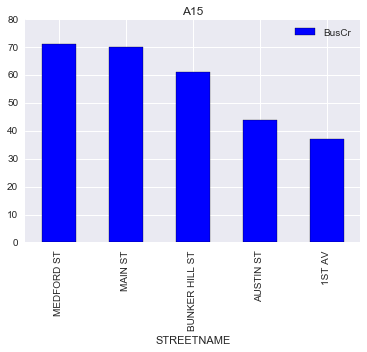

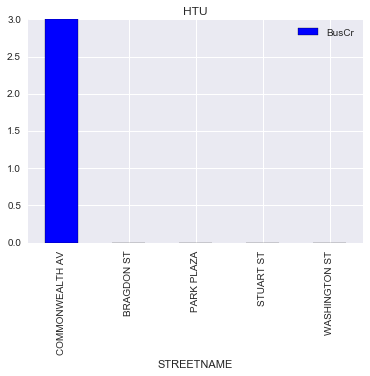

In [115]:
# create a pivot table that classifies streets by the number of business crimes

business_crimes = ['COMMERCIAL BURGLARY', 'VANDALISM', 'ROBBERY', 'OTHER LARCENY', 'BurgTools', 'ARSON', 'Larceny'\
                  'Other Burglary', 'PROSTITUTION CHARGES', 'PubDrink']

def is_bus_cr(c):
    if c in business_crimes:
        return 1
    else:
        return 0
    
crime['BusCr'] =  crime['INCIDENT_TYPE_DESCRIPTION'].map(is_bus_cr)
dists = crime['REPTDISTRICT'].unique().tolist()

#Removes NaN; will only work if nan is the last one.
dists.pop()

for d in dists:
    var = crime.loc[crime.REPTDISTRICT == d]
    streets = pd.DataFrame(pd.pivot_table(var, values = 'BusCr', index = 'STREETNAME', aggfunc = 'sum'))
    streets.sort_values('BusCr', ascending = False, inplace = True)
    top_five = streets.head(5)
    top_five.plot(kind = 'bar', title = d)
    #total = streets.BusCr.sum()
    #top_five['Proportion_here'] = top_five.BusCr / total